In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pulp
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [36]:
gold_price = pd.read_csv(r'LBMA-GOLD.csv')
bit_price = pd.read_csv(r'BCHAIN-MKPRU.csv')

In [37]:
# 计算收益率
gold_price['收益率'] = [0]+[(gold_price['USD (PM)'][i+1]-gold_price['USD (PM)'][i])/gold_price['USD (PM)'][i] for i in range(gold_price.shape[0]-1)]
bit_price['收益率'] = [0]+[(bit_price['Value'][i+1]-bit_price['Value'][i])/bit_price['Value'][i] for i in range(bit_price.shape[0]-1)]

In [38]:
def data_process(frame):
    date_list = []
    for item in frame['Date']:
        if item[:3] == '200':
            date_list.append(item[3:])
        elif item[:2] == '20':
            date_list.append(item[2:])
        else:
            date_list.append(item)
    return date_list

gold_price['Date'] = [data_process(gold_price)[i][:-2]+'20'+data_process(gold_price)[i][-2:] for i in range(gold_price.shape[0])]
bit_price['Date'] = [data_process(bit_price)[i][:-2]+'20'+data_process(bit_price)[i][-2:] for i in range(bit_price.shape[0])]

In [39]:
gold_price['Date'] = gold_price['Date'].apply(lambda x:datetime.strptime(x, '%m/%d/%Y'))
bit_price['Date'] = bit_price['Date'].apply(lambda x:datetime.strptime(x, '%m/%d/%Y'))

In [40]:
gold_price['相对价格'] = [1]+[gold_price['USD (PM)'][i+1]/gold_price['USD (PM)'][i] for i in range(gold_price.shape[0]-1)]
bit_price['相对价格'] = [1]+[bit_price['Value'][i+1]/bit_price['Value'][i] for i in range(bit_price.shape[0]-1)]

In [41]:
gold_price.set_index('Date', inplace=True)
bit_price.set_index('Date', inplace=True)

<AxesSubplot:title={'center':'gold'}, xlabel='Date'>

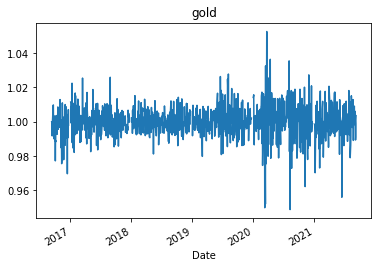

In [42]:
gold_price['相对价格'].plot(title='gold')

In [43]:
gold_price.dropna(axis=0, how='any', inplace=True)
bit_price.dropna(axis=0, how='any', inplace=True)

In [44]:
gold_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1245 entries, 2016-09-12 to 2021-09-10
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   USD (PM)  1245 non-null   float64
 1   收益率       1245 non-null   float64
 2   相对价格      1245 non-null   float64
dtypes: float64(3)
memory usage: 38.9 KB


In [45]:
gold_price.head()

,USD (PM),收益率,相对价格
Date,,,
2016-09-12,1324.60,0.000000,1.000000
2016-09-13,1323.65,-0.000717,0.999283
2016-09-14,1321.75,-0.001435,0.998565
2016-09-15,1310.80,-0.008284,0.991716
2016-09-16,1308.35,-0.001869,0.998131


In [46]:
bit_price.head()

,Value,收益率,相对价格
Date,,,
2016-09-11,621.65,0.000000,1.000000
2016-09-12,609.67,-0.019271,0.980729
2016-09-13,610.92,0.002050,1.002050
2016-09-14,608.82,-0.003437,0.996563
2016-09-15,610.38,0.002562,1.002562


## 预测模型（LSTM）

In [414]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# gold_scale = scaler.fit_transform(gold_price['收益率'].values.reshape(-1,1))
# bit_scale = scaler.fit_transform(bit_price['收益率'].values.reshape(-1,1))
gold_scale = gold_price['相对价格'].values.reshape(-1, 1)
bit_scale = bit_price['相对价格'].values.reshape(-1, 1)

def train_test(dataset):
    train_size = int(len(dataset) * 0.65)
    trainlist = dataset[:train_size]
    testlist = dataset[train_size:]
    return trainlist, testlist
gold_trainlist, gold_testlist = train_test(gold_scale)
bit_trainlist, bit_testlist = train_test(bit_scale)

In [415]:
gold_trainlist

array([[1.        ],
       [0.9992828 ],
       [0.99856458],
       [0.99171553],
       [0.99813091],
       [1.00496809],
       [0.99920143],
       [1.00936216],
       [1.00980318],
       [0.99966395],
       [1.00138199],
       [0.98992913],
       [0.99660889],
       [0.99667297],
       [1.00333814],
       [0.99304348],
       [0.97715678],
       [0.98916855],
       [0.98826217],
       [1.0033878 ],
       [1.00059583],
       [0.99519651],
       [1.00243328],
       [1.00362117],
       [0.99262519],
       [1.00243659],
       [1.0027096 ],
       [1.00862343],
       [1.00204878],
       [0.99559627],
       [0.99960507],
       [1.00304216],
       [1.00086655],
       [0.99665486],
       [1.0053307 ],
       [0.99921445],
       [1.01293239],
       [1.01187473],
       [0.9978907 ],
       [1.00138355],
       [0.98484034],
       [0.99945443],
       [0.99925917],
       [0.98915249],
       [0.97550296],
       [0.98151967],
       [1.01100033],
       [1.001

In [416]:
def create_dataset(dataset, look_back):
#这里的look_back与timestep相同
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX),np.array(dataY)
#训练数据太少 look_back并不能过大
look_back = 1
gold_trainX, gold_trainY = create_dataset(gold_trainlist,look_back)
gold_testX, gold_testY = create_dataset(gold_testlist,look_back)

bit_trainX, bit_trainY = create_dataset(bit_trainlist,look_back)
bit_testX, bit_testY = create_dataset(bit_testlist,look_back)

In [417]:
bit_trainY

array([[0.98072871],
       [1.00205029],
       [0.99656256],
       ...,
       [0.99438732],
       [1.00233983],
       [0.97541074]])

In [418]:
gold_trainX = np.reshape(gold_trainX, (gold_trainX.shape[0], gold_trainX.shape[1], 1))
gold_testX = np.reshape(gold_testX, (gold_testX.shape[0], gold_testX.shape[1] ,1 ))

bit_trainX = np.reshape(bit_trainX, (bit_trainX.shape[0], bit_trainX.shape[1], 1))
bit_testX = np.reshape(bit_testX, (bit_testX.shape[0], bit_testX.shape[1] ,1 ))

In [419]:
print(len(bit_trainX))
print(len(bit_testX))

1185
639


### 相对价格

In [429]:
model = Sequential()
model.add(LSTM(4, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(gold_trainX, gold_trainY, epochs=50, batch_size=32, verbose=2)
# model.save(os.path.join("gold_LSTM_predict" + ".h5"))

Epoch 1/50
26/26 - 2s - loss: 0.9354 - 2s/epoch - 65ms/step
Epoch 2/50
26/26 - 0s - loss: 0.8090 - 51ms/epoch - 2ms/step
Epoch 3/50
26/26 - 0s - loss: 0.6861 - 44ms/epoch - 2ms/step
Epoch 4/50
26/26 - 0s - loss: 0.5669 - 46ms/epoch - 2ms/step
Epoch 5/50
26/26 - 0s - loss: 0.4535 - 50ms/epoch - 2ms/step
Epoch 6/50
26/26 - 0s - loss: 0.3489 - 51ms/epoch - 2ms/step
Epoch 7/50
26/26 - 0s - loss: 0.2563 - 47ms/epoch - 2ms/step
Epoch 8/50
26/26 - 0s - loss: 0.1786 - 49ms/epoch - 2ms/step
Epoch 9/50
26/26 - 0s - loss: 0.1172 - 45ms/epoch - 2ms/step
Epoch 10/50
26/26 - 0s - loss: 0.0721 - 45ms/epoch - 2ms/step
Epoch 11/50
26/26 - 0s - loss: 0.0413 - 46ms/epoch - 2ms/step
Epoch 12/50
26/26 - 0s - loss: 0.0220 - 45ms/epoch - 2ms/step
Epoch 13/50
26/26 - 0s - loss: 0.0109 - 43ms/epoch - 2ms/step
Epoch 14/50
26/26 - 0s - loss: 0.0050 - 44ms/epoch - 2ms/step
Epoch 15/50
26/26 - 0s - loss: 0.0021 - 42ms/epoch - 2ms/step
Epoch 16/50
26/26 - 0s - loss: 8.8298e-04 - 45ms/epoch - 2ms/step
Epoch 17/50
26

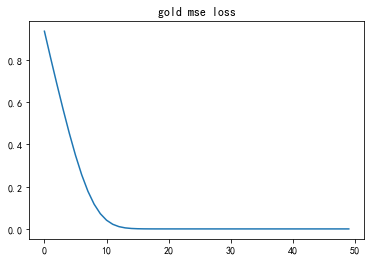

In [431]:
mse_history = history.history['loss']
plt.plot(mse_history)
plt.title('gold mse loss')
plt.show()

In [432]:
gold_testPredict = model.predict(gold_testlist)
gold_trainPredict = model.predict(gold_trainlist)
#反归一化
# gold_trainPredict = scaler.inverse_transform(gold_trainPredict)
# gold_testPredict = scaler.inverse_transform(gold_testPredict)

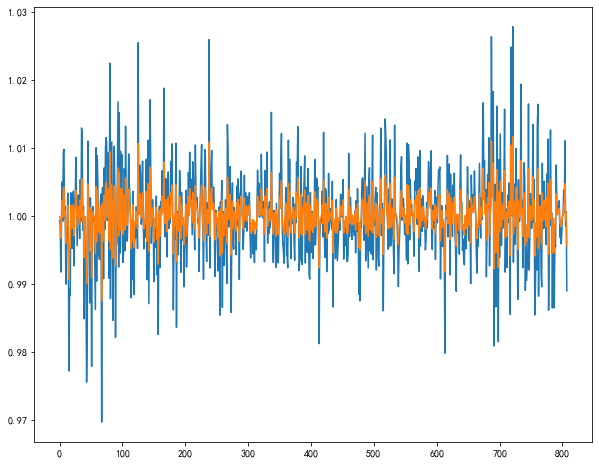

In [434]:
# 训练效果
plt.figure(figsize=(10,8))
plt.plot(gold_trainY)
plt.plot(gold_trainPredict[1:])
plt.show()

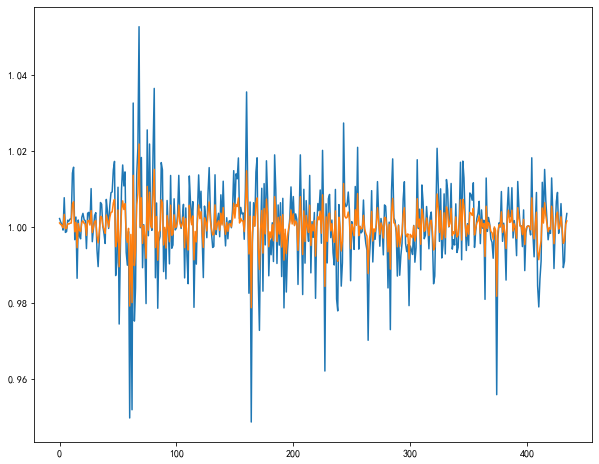

In [435]:
# 测试效果
plt.figure(figsize=(10,8))
plt.plot(gold_testY)
plt.plot(gold_testPredict[1:])
plt.show()

In [466]:
model = Sequential()
model.add(LSTM(4, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(bit_trainX, bit_trainY, epochs=50, batch_size=32, verbose=2)
# model.save(os.path.join("bit_LSTM_predict" + ".h5"))

Epoch 1/50
38/38 - 2s - loss: 0.7934 - 2s/epoch - 45ms/step
Epoch 2/50
38/38 - 0s - loss: 0.6425 - 62ms/epoch - 2ms/step
Epoch 3/50
38/38 - 0s - loss: 0.4915 - 61ms/epoch - 2ms/step
Epoch 4/50
38/38 - 0s - loss: 0.3470 - 65ms/epoch - 2ms/step
Epoch 5/50
38/38 - 0s - loss: 0.2211 - 62ms/epoch - 2ms/step
Epoch 6/50
38/38 - 0s - loss: 0.1236 - 62ms/epoch - 2ms/step
Epoch 7/50
38/38 - 0s - loss: 0.0597 - 65ms/epoch - 2ms/step
Epoch 8/50
38/38 - 0s - loss: 0.0248 - 62ms/epoch - 2ms/step
Epoch 9/50
38/38 - 0s - loss: 0.0094 - 65ms/epoch - 2ms/step
Epoch 10/50
38/38 - 0s - loss: 0.0039 - 67ms/epoch - 2ms/step
Epoch 11/50
38/38 - 0s - loss: 0.0023 - 68ms/epoch - 2ms/step
Epoch 12/50
38/38 - 0s - loss: 0.0020 - 61ms/epoch - 2ms/step
Epoch 13/50
38/38 - 0s - loss: 0.0019 - 55ms/epoch - 1ms/step
Epoch 14/50
38/38 - 0s - loss: 0.0019 - 67ms/epoch - 2ms/step
Epoch 15/50
38/38 - 0s - loss: 0.0019 - 67ms/epoch - 2ms/step
Epoch 16/50
38/38 - 0s - loss: 0.0019 - 62ms/epoch - 2ms/step
Epoch 17/50
38/38 

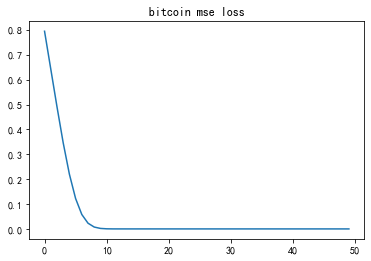

In [467]:
mse_history = history.history['loss']
plt.plot(mse_history)
plt.title('bitcoin mse loss')
plt.show()

In [468]:
bit_testPredict = model.predict(bit_testlist)
bit_trainPredict = model.predict(bit_trainlist)

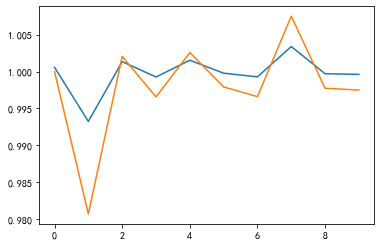

In [469]:
plt.plot(bit_trainPredict[:10])
plt.plot(bit_trainX[:10].reshape(10,1))

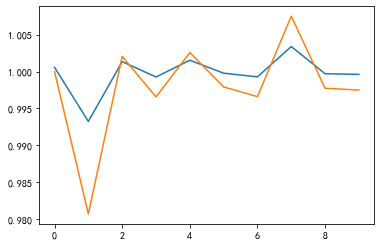

In [474]:
plt.plot(bit_trainPredict[:10])
plt.plot(bit_price['相对价格'].values[:10])

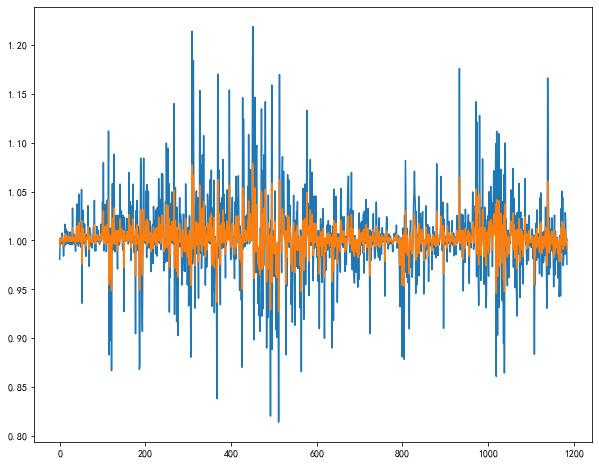

In [471]:
# 训练效果
plt.figure(figsize=(10,8))
plt.plot(bit_trainY)
plt.plot(bit_trainPredict[1:])
plt.show()

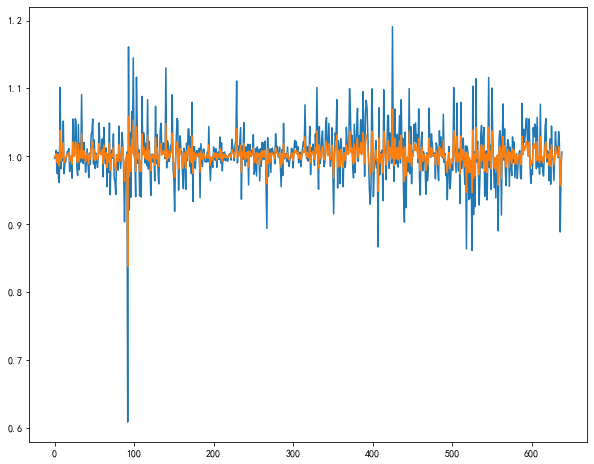

In [472]:
# 测试效果
plt.figure(figsize=(10,8))
plt.plot(bit_testY)
plt.plot(bit_testPredict[1:])
plt.show()

### 价格

In [ ]:
# gold_price_scale = gold_price['USD (PM)'].values.reshape(-1, 1)
# bit_price_scale = bit_price['Value'].values.reshape(-1, 1)

# gold_price_trainlist, gold_price_testlist = train_test(gold_price_scale)
# bit_price_trainlist, bit_price_testlist = train_test(bit_price_scale)

In [ ]:
# gold_price_trainX, gold_price_trainY = create_dataset(gold_price_trainlist,look_back)
# gold_price_testX, gold_price_testY = create_dataset(gold_price_testlist,look_back)

# bit_price_trainX, bit_price_trainY = create_dataset(bit_price_trainlist,look_back)
# bit_price_testX, bit_price_testY = create_dataset(bit_price_testlist,look_back)

In [ ]:
# gold_price_trainX = np.reshape(gold_price_trainX, (gold_price_trainX.shape[0], gold_trainX.shape[1], 1))
# gold_price_testX = np.reshape(gold_price_testX, (gold_price_testX.shape[0], gold_testX.shape[1] ,1 ))

# bit_trainX = np.reshape(bit_trainX, (bit_trainX.shape[0], bit_trainX.shape[1], 1))
# bit_testX = np.reshape(bit_testX, (bit_testX.shape[0], bit_testX.shape[1] ,1 ))

In [487]:
gold_predict = gold_price['预测相对价格'].values
bit_predict = bit_price['预测相对价格'].values
gold_fate = 0.01
bit_fate = 0.02

# 对黄金缺失值做处理
gold_list = []
gold_index = []
gold_true = []
bit_true = bit_price['相对价格'].tolist()
bit_list = bit_price['预测相对价格'].tolist()
for item in bit_price.index:
    if item in gold_price.index:
        gold_list.append(gold_price.loc[item, "预测相对价格"])
        gold_index.append(gold_price.loc[item, "预测相对价格"])
        gold_true.append(gold_price.loc[item, "相对价格"])
    else:
        gold_list.append(1)
        gold_index.append('no date')
        gold_true.append(1)
print(len(gold_list) == len(bit_list))

True


In [193]:
# from scipy import optimize
# state = [(0.5, 0.5)]    # 初始投资组合
# for gold, bit in zip(gold_list[1:], bit_list[1:]):
#     A_ub = np.array([[1, -1, 0, 0], [0, 0, 1, -1], [-1, 1, -1, 1], [1, -1, 1, -1]])
#     b_ub = np.array([state[-1][0], state[-1][1], 1-state[-1][0] - state[-1][1], state[-1][0] + state[-1][1]])
#     # if gold != 'no date':
#     c = np.array([(-gold-gold_fate), (gold-gold_fate), (-bit-bit_fate), (bit-bit_fate)])
#     res = optimize.linprog(-c, A_ub, b_ub)
#     v1, u1, v2, u2 = -res['x'][0], -res['x'][1], -res['x'][2], -res['x'][3]
#     state.append((u1-v1+state[-1][0], u2-v2+state[-1][1]))

In [503]:
state = [(0.5, 0.5)]    # 初始投资组合
F = []
for gold, bit, sign in zip(gold_list[1:], bit_list[1:], gold_index[1:]):
    if sign != 'no date':
        MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
        v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
        v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
        u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
        u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
        MyProbLP += (gold-0.01)*u1-(gold+0.01)*v1+(bit-0.02)*u2-(bit+0.02)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
        MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
        MyProbLP += (u1+v1<=0.3)  # 不等式约束
        MyProbLP += (u1+v1>=0)
        MyProbLP += (u2+v2>=0)
        MyProbLP += (u2+v2<=0.3)
        MyProbLP.solve()
        F.append(pulp.value(MyProbLP.objective))
        res = []
    #     print("Status:", pulp.LpStatus[MyProbLP.status]) # 输出求解状态
        for v in MyProbLP.variables():
            res.append(v.varValue)
        state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))
    else:
        MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
        v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
        v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
        u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
        u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
        MyProbLP += (gold-1000)*u1-(gold+1000)*v1+(bit-0.02)*u2-(bit+0.02)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
        MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
        MyProbLP += (u1+v1<=0.3)  # 不等式约束
        MyProbLP += (u1+v1>=0)
        MyProbLP += (u2+v2>=0)
        MyProbLP += (u2+v2<=0.3)
        MyProbLP.solve()
        F.append(pulp.value(MyProbLP.objective))
        res = []
        for v in MyProbLP.variables():
            res.append(v.varValue)
        state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))

<AxesSubplot:xlabel='Date'>

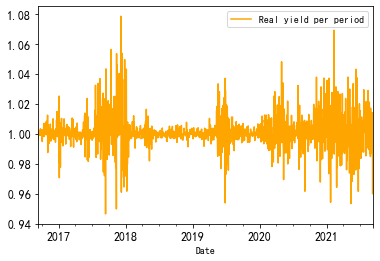

In [530]:
# plt.figure(figsize=(10,8))
pd.DataFrame(F, columns=['Real yield per period'], index=bit_price.index[1:]).plot(color='orange',fontsize=12)

# plt.plot(F, color='orange')
# plt.title('')
# plt.show()

In [494]:
with open('投资比例.txt', 'w') as f:
    f.write('{}\t{}\n'.format('黄金','比特币'))
    for i, j in state:
        if i<=0:
            f.write("{}\t{}\n".format(0.0, 1.0))
        elif j<=0:
            f.write("{}\t{}\n".format(1.0, 0.0))
        else:
            f.write("{}\t{}\n".format(i, j))

## 计算累计收益

In [508]:
z = 1000
i = 1
true_profit = [1000]
for s1,s2 in state[1:]:
    z = z*(state[i][0]*gold_true[i]+state[i][1]*bit_true[i]-np.abs(state[i][0]-state[i-1][0])*0.01-np.abs(state[i][1]-state[i-1][1])*0.02) 
    i += 1
    true_profit.append(z)
print(z)

196514.585114145


In [492]:
z = 1000
i = 1
pred_profit = [1000]
for s1,s2 in state[1:]:
    z = z*(state[i][0]*gold_list[i]+state[i][1]*bit_list[i]-np.abs(state[i][0]-state[i-1][0])*0.01-np.abs(state[i][1]-state[i-1][1])*0.02) 
    i += 1
    pred_profit.append(z)
print(z)

9027.731219023948


In [509]:
len(true_profit)

1826

<Figure size 720x576 with 0 Axes>

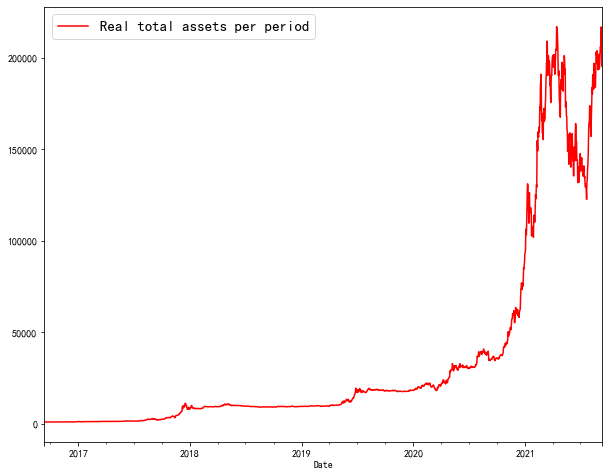

In [523]:
asset = pd.DataFrame(columns=['Real total assets per period'], index=bit_price.index)
# asset['每期真实总资产'] = true_profit
# asset['每期预测总资产'] = pred_profit
# asset['真实与预测总资产差值'] = np.array(true_profit)-np.array(pred_profit)
plt.figure(figsize=(10, 8))
asset['Real total assets per period'] = true_profit
asset.plot(figsize=(10,8),color='red')
plt.legend(loc='best', fontsize=15)

In [500]:
sentive_list = []
for z in range(500, 5000, 100):
    i = 1
    for s1,s2 in state[1:]:
        z = z*(state[i][0]*gold_true[i]+state[i][1]*bit_true[i]-np.abs(state[i][0]-state[i-1][0])*0.01-np.abs(state[i][1]-state[i-1][1])*0.02)
        i += 1
    sentive_list.append(z)

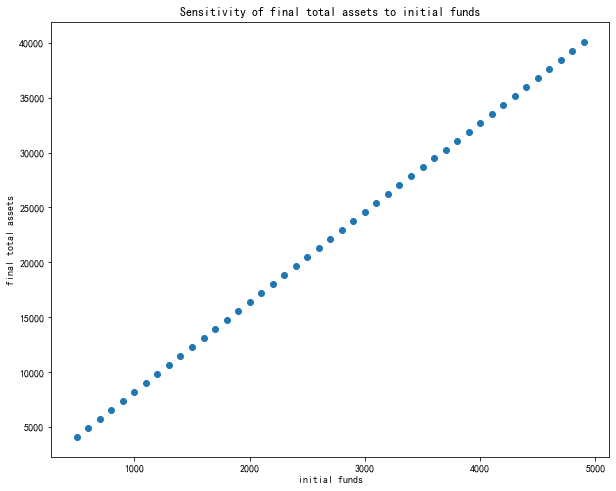

In [524]:
plt.figure(figsize=(10,8))
plt.scatter([z for z in range(500, 5000, 100)], sentive_list, label='')
plt.title('Sensitivity of final total assets to initial funds')
plt.xlabel('initial funds')
plt.ylabel('final total assets')
plt.show()

In [506]:
(sentive_list[-1]-sentive_list[0])/4500

8.002024738355518

## 交易费用敏感度

In [498]:
list_sentive = []
for gold_fate in [0.01, 0.02, 0.03, 0.05]:
    for bit_fate in [0.01, 0.02, 0.03, 0.05]:
        state = [(0.5, 0.5)]    # 初始投资组合
        F = []
        for gold, bit, sign in zip(gold_list[1:], bit_list[1:], gold_index[1:]):
            if sign != 'no date':
                MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
                v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
                v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
                u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
                u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
                MyProbLP += (gold-gold_fate)*u1-(gold+gold_fate)*v1+(bit-bit_fate)*u2-(bit+bit_fate)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
                MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
                MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
                MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
                MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
                MyProbLP += (u1+v1<=0.3)  # 不等式约束
                MyProbLP += (u1+v1>=0)
                MyProbLP += (u2+v2>=0)
                MyProbLP += (u2+v2<=0.3)
                MyProbLP.solve()
                F.append(pulp.value(MyProbLP.objective))
                res = []
            #     print("Status:", pulp.LpStatus[MyProbLP.status]) # 输出求解状态
                for v in MyProbLP.variables():
                    res.append(v.varValue)
                state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))
            else:
                MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
                v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
                v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
                u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
                u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
                MyProbLP += (gold-1000)*u1-(gold+1000)*v1+(bit-bit_fate)*u2-(bit+bit_fate)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
                MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
                MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
                MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
                MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
                MyProbLP += (u1+v1<=0.3)  # 不等式约束
                MyProbLP += (u1+v1>=0)
                MyProbLP += (u2+v2>=0)
                MyProbLP += (u2+v2<=0.3)
                MyProbLP.solve()
                F.append(pulp.value(MyProbLP.objective))
                res = []
                for v in MyProbLP.variables():
                    res.append(v.varValue)
                state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))
        z = 1000
        i = 1
        for s1,s2 in state[1:]:
            z = z*(state[i][0]*gold_true[i]+state[i][1]*bit_true[i]-np.abs(state[i][0]-state[i-1][0])*0.01-np.abs(state[i][1]-state[i-1][1])*0.02)
            i += 1
        list_sentive.append([gold_fate, bit_fate, z])

<AxesSubplot:xlabel='Date'>

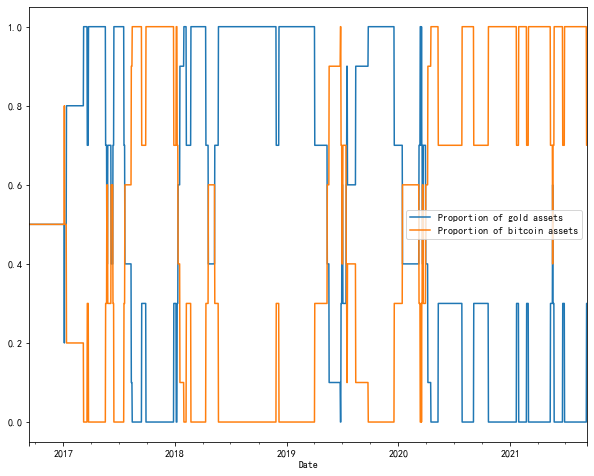

In [495]:
a = []
b = []
with open('投资比例.txt', 'r') as f:
    for line in f.readlines():
        line=line.strip('\n').split('\t')
        a.append(line[0])
        b.append(line[1])
c = pd.DataFrame(index=bit_price.index, columns=['Proportion of gold assets','Proportion of bitcoin assets'])
c['Proportion of gold assets'] = [float(i) for i in a[1:]]
c['Proportion of bitcoin assets'] = [float(i) for i in b[1:]]
c.plot(figsize=(10, 8))

## 均方根误差

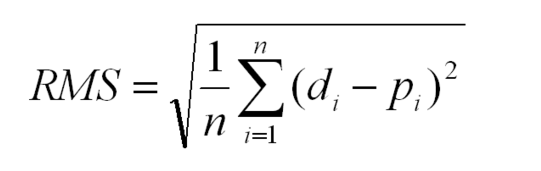

In [481]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [482]:
rmse(gold_price['相对价格'].values, gold_price['预测相对价格'].values)

0.005060599535328808

In [483]:
rmse(bit_price['相对价格'].values, bit_price['预测相对价格'].values)

0.025843929615840203

## 风险厌恶与风险偏好

In [568]:
state = [(0.5, 0.5)]    # 初始投资组合
F = []
for gold, bit, sign in zip(gold_list[1:], bit_list[1:], gold_index[1:]):
    if sign != 'no date':
        MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
        v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
        v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
        u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
        u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
        MyProbLP += (gold-0.01)*u1-(gold+0.01)*v1+(bit-0.02)*u2-(bit+0.02)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
        MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
        MyProbLP += (u1+v1<=0.35)  # 不等式约束
        MyProbLP += (u1+v1>=0)
        MyProbLP += (u2+v2>=0)
        MyProbLP += (u2+v2<=0.25)
        MyProbLP.solve()
        F.append(pulp.value(MyProbLP.objective))
        res = []
    #     print("Status:", pulp.LpStatus[MyProbLP.status]) # 输出求解状态
        for v in MyProbLP.variables():
            res.append(v.varValue)
        state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))
    else:
        MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
        v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
        v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
        u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
        u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
        MyProbLP += (gold-1000)*u1-(gold+1000)*v1+(bit-0.02)*u2-(bit+0.02)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
        MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
        MyProbLP += (u1+v1<=0.35)  # 不等式约束
        MyProbLP += (u1+v1>=0)
        MyProbLP += (u2+v2>=0)
        MyProbLP += (u2+v2<=0.25)
        MyProbLP.solve()
        F.append(pulp.value(MyProbLP.objective))
        res = []
        for v in MyProbLP.variables():
            res.append(v.varValue)
        state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))

In [569]:
z = 1000
i = 1
neg_true_profit = [1000]
for s1,s2 in state[1:]:
    z = z*(state[i][0]*gold_true[i]+state[i][1]*bit_true[i]-np.abs(state[i][0]-state[i-1][0])*0.01-np.abs(state[i][1]-state[i-1][1])*0.02) 
    i += 1
    neg_true_profit.append(z)
print(z)

143590.95921271475


<Figure size 720x576 with 0 Axes>

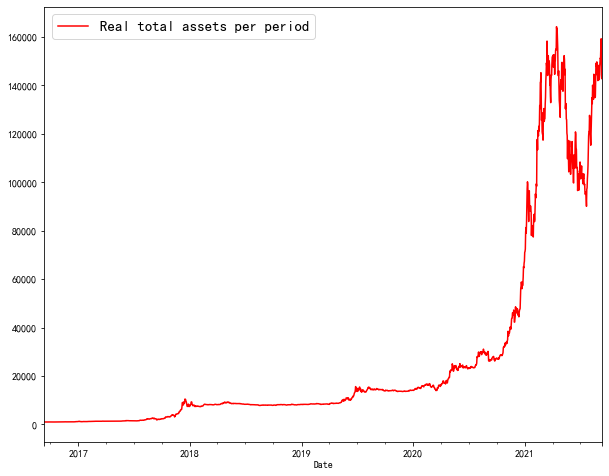

In [546]:
asset = pd.DataFrame(columns=['Real total assets per period for Risk-averse', 'Real total assets per period for Risk-averse'], index=bit_price.index)
# asset['每期真实总资产'] = true_profit
# asset['每期预测总资产'] = pred_profit
# asset['真实与预测总资产差值'] = np.array(true_profit)-np.array(pred_profit)
plt.figure(figsize=(10, 8))
asset['Real total assets per period for Risk-averse'] = neg_true_profit
asset['Real total assets per period for Risk-prefer'] = pos_true_profit
asset.plot(figsize=(10,8),color='red')
plt.legend(loc='best', fontsize=15)

In [570]:
state = [(0.5, 0.5)]    # 初始投资组合
F = []
for gold, bit, sign in zip(gold_list[1:], bit_list[1:], gold_index[1:]):
    if sign != 'no date':
        MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
        v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
        v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
        u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
        u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
        MyProbLP += (gold-0.01)*u1-(gold+0.01)*v1+(bit-0.02)*u2-(bit+0.02)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
        MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
        MyProbLP += (u1+v1<=0.2)  # 不等式约束
        MyProbLP += (u1+v1>=0)
        MyProbLP += (u2+v2>=0)
        MyProbLP += (u2+v2<=0.4)
        MyProbLP.solve()
        F.append(pulp.value(MyProbLP.objective))
        res = []
    #     print("Status:", pulp.LpStatus[MyProbLP.status]) # 输出求解状态
        for v in MyProbLP.variables():
            res.append(v.varValue)
        state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))
    else:
        MyProbLP = pulp.LpProblem("LPProbDemo1", sense=pulp.LpMaximize)
        v1 = pulp.LpVariable('v1',lowBound=0, cat='Continuous') 
        v2 = pulp.LpVariable('v2',lowBound=0, cat='Continuous') 
        u1 = pulp.LpVariable('u1',lowBound=0, cat='Continuous') 
        u2 = pulp.LpVariable('u2',lowBound=0, cat='Continuous') 
        MyProbLP += (gold-1000)*u1-(gold+1000)*v1+(bit-0.02)*u2-(bit+0.02)*v2+state[-1][0]*gold+state[-1][1]*bit  # 设置目标函数
        MyProbLP += (u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]>=0)  # 不等式约束
        MyProbLP += (u1-v1+state[-1][0]+u2-v2+state[-1][1]<=1)  # 不等式约束
        MyProbLP += (u1+v1<=0.2)  # 不等式约束
        MyProbLP += (u1+v1>=0)
        MyProbLP += (u2+v2>=0)
        MyProbLP += (u2+v2<=0.4)
        MyProbLP.solve()
        F.append(pulp.value(MyProbLP.objective))
        res = []
        for v in MyProbLP.variables():
            res.append(v.varValue)
        state.append((res[0]-res[2]+state[-1][0], res[1]-res[3]+state[-1][1]))

In [571]:
z = 1000
i = 1
pos_true_profit = [1000]
for s1,s2 in state[1:]:
    z = z*(state[i][0]*gold_true[i]+state[i][1]*bit_true[i]-np.abs(state[i][0]-state[i-1][0])*0.01-np.abs(state[i][1]-state[i-1][1])*0.02) 
    i += 1
    pos_true_profit.append(z)
print(z)

91447.60203737215


In [578]:
neg_true_profit == pos_true_profit

False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


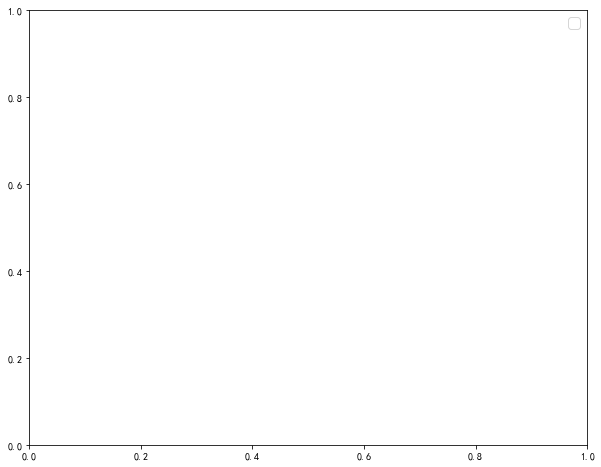

In [576]:
asset = pd.DataFrame(columns=['Real total assets per period for Risk-averse', 'Real total assets per period for Risk-prefer'], index=bit_price.index)
# asset['每期真实总资产'] = true_profit
# asset['每期预测总资产'] = pred_profit
# asset['真实与预测总资产差值'] = np.array(true_profit)-np.array(pred_profit)
plt.figure(figsize=(10, 8))
asset['Real total assets per period for Risk-averse'] = neg_true_profit
asset['Real total assets per period for Risk-prefer'] = pos_true_profit
plt.legend(loc='best', fontsize=15)

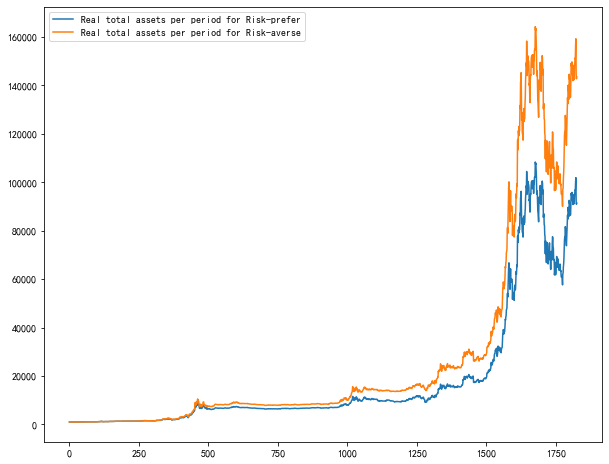

In [582]:
plt.figure(figsize=(10, 8))
plt.plot(pos_true_profit, label='Real total assets per period for Risk-prefer')
plt.plot(neg_true_profit, label='Real total assets per period for Risk-averse')
plt.legend(loc='best')

## 投资组合策略

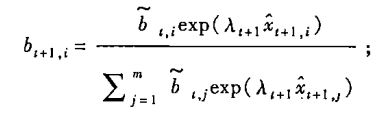

In [479]:
# 预测黄金与比特币全部的相对价格
gold_x = np.vstack([gold_trainPredict, gold_testPredict])
bit_x = np.vstack([bit_trainPredict, bit_testPredict])

In [480]:
gold_price['预测相对价格'] = gold_x
bit_price['预测相对价格'] = bit_x

In [ ]:
def proportion(i, state, predict_gold, predict_bit):
    return state[i-1][0]*np.exp(lam[i]*predict_gold[i])/(state[i-1][0]*np.exp(lam[i]*predict_gold[i])+state[i-1][1]*np.exp(lam[i]*predict_bit[i]))

In [159]:
state = [(0.4, 0.6)]
lam=[0.04 for i in range(gold_price.shape[0])]
for i in range(1, gold_price.shape[0]):
    state.append((state[i-1][0]*np.exp(lam[i]*gold_x[i])/(state[i-1][0]*np.exp(lam[i]*gold_x[i])+state[i-1][1]*np.exp(lam[i]*bit_x[i])), 
                  state[i-1][1]*np.exp(lam[i]*bit_x[i])/(state[i-1][0]*np.exp(lam[i]*gold_x[i])+state[i-1][1]*np.exp(lam[i]*bit_x[i]))))

<AxesSubplot:xlabel='Date'>

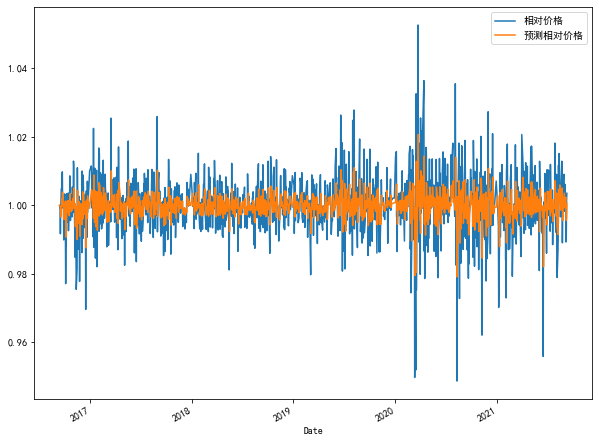

In [166]:
gold_price.loc[:,['相对价格','预测相对价格']].plot(figsize=(10, 8))

In [160]:
state

[(0.4, 0.6),
 (array([0.3999776]), array([0.6000224])),
 (array([0.40004081]), array([0.59995919])),
 (array([0.40000353]), array([0.59999647])),
 (array([0.39996492]), array([0.60003508])),
 (array([0.39992364]), array([0.60007636])),
 (array([0.39992982]), array([0.60007018])),
 (array([0.39991989]), array([0.60008011])),
 (array([0.39989928]), array([0.60010072])),
 (array([0.39992485]), array([0.60007515])),
 (array([0.39991263]), array([0.60008737])),
 (array([0.39996916]), array([0.60003084])),
 (array([0.39991908]), array([0.60008092])),
 (array([0.39990919]), array([0.60009081])),
 (array([0.39979891]), array([0.60020109])),
 (array([0.39980553]), array([0.60019447])),
 (array([0.39977731]), array([0.60022269])),
 (array([0.39961345]), array([0.60038655])),
 (array([0.39955149]), array([0.60044851])),
 (array([0.39949757]), array([0.60050243])),
 (array([0.39944638]), array([0.60055362])),
 (array([0.39938568]), array([0.60061432])),
 (array([0.39935848]), array([0.60064152])),

## 分类模型？（target为买入、卖出、持有）

$$如果该期价格大于后一期价格，则该卖出；否则买入$$

In [30]:
def label(frame, col_name):
    label_list=[]
    for i in range(frame.shape[0]-1):
        if frame[col_name][i]-frame[col_name][i+1]<0:
            label_list.append(1)
        elif frame[col_name][i]-frame[col_name][i+1]>0:
            label_list.append(-1)
        else:
            label_list.append(0)
    return label_list

gold_target = label(gold_price, 'USD (PM)')
bit_target = label(bit_price, 'Value')

## black-letterman模型

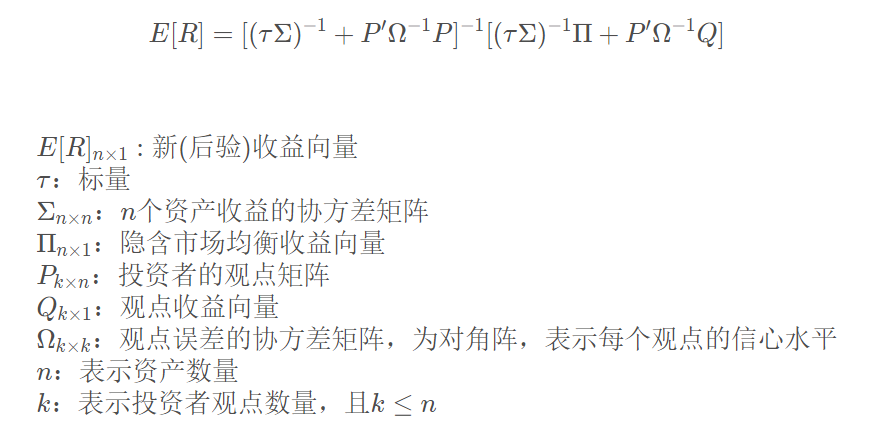

In [550]:
import numpy as np
import pandas as pd
from numpy import linalg
def blacklitterman(returns,tau,P,Q):
    mu = returns.mean()
    sigma = returns.cov()
    pil = np.expand_dims(mu,axis = 0).T     
    ts = tau * sigma
    ts_1 = linalg.inv(ts)
    Omega = np.dot(np.dot(P,ts), P.T)* np.eye(Q.shape[0])
    Omega_1 = linalg.inv(Omega)
    er = np.dot(linalg.inv(ts_1 + np.dot(np.dot(P.T,Omega_1),P)),(np.dot(ts_1 ,pil)+np.dot(np.dot(P.T,Omega_1),Q)))
    posterirorSigma = linalg.inv(ts_1 + np.dot(np.dot(P.T,Omega_1),P))
    return [er, posterirorSigma]

In [552]:
pick1 = np.array([1,0])        # 投资者观点矩阵
q1 = np.array([0.003*4])
pick2 = np.array([0.5,0.5])     # 投资者观点矩阵（观点2）
q2 = np.array([0.001])
P = np.array([pick1,pick2])
Q = np.array([q1,q2])

In [553]:
sh_return = pd.concat([gold_price['收益率'], bit_price['收益率']],axis=1)
print(sh_return)
res = blacklitterman(sh_return,0.1,P,Q)
p_mean = pd.DataFrame(res[0],index = sh_return.columns, columns = ['posterior_mean'])
p_cov = res[1]
print(p_mean)
print(p_cov)

                 收益率       收益率
Date                          
2016-09-11       NaN  0.000000
2016-09-12  0.000000 -0.019271
2016-09-13 -0.000717  0.002050
2016-09-14 -0.001435 -0.003437
2016-09-15 -0.008284  0.002562
...              ...       ...
2021-09-06 -0.001152  0.036472
2021-09-07 -0.010677  0.017546
2021-09-08 -0.008962 -0.111399
2021-09-09  0.001260 -0.015612
2021-09-10  0.003551  0.006300

[1826 rows x 2 columns]
     posterior_mean
收益率        0.005984
收益率        0.000518
[[ 3.67459303e-06 -1.28529387e-06]
 [-1.28529387e-06  8.90720327e-05]]


In [554]:
def blminVar(blres, goalRet):
    covs = np.array(blres[1],dtype=float)
    means = np.array(blres[0],dtype=float)
    L1 = np.append(np.append(covs.swapaxes(0,1),[means.flatten()],axis=0),
                   [np.ones(len(means))],axis=0).swapaxes(0,1)

    L2 = list(np.ones(len(means)))
    L2.extend([0,0])
    L3 = list(means)
    L3.extend([0,0])
    L4 = np.array([L2,L3],dtype=float)
    L = np.append(L1,L4,axis=0)
    results = linalg.solve(L,np.append(np.zeros(len(means)),[1,goalRet]))

    return pd.DataFrame(results[:-2],columns = ['p_weight'])

blresult = blminVar(res,0.70/252)
print(blresult)

   p_weight
0  0.413465
1  0.586535


In [560]:
z = 1000
i = 1
true_profit = [1000]
for s1,s2 in state[1:]:
    z = z*(blresult.values[0]*gold_true[i]+blresult.values[1]*bit_true[i]-np.abs(blresult.values[0]-blresult.values[0])*0.01-np.abs(blresult.values[1]-blresult.values[1])*0.02) 
    i += 1
    true_profit.append(z)
print(z)

[20231.02183029]


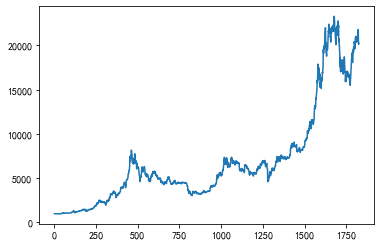

In [566]:
plt.plot(true_profit)

In [564]:
np.std(bit_price['相对价格'])

0.041464499195238605

In [565]:
np.std(gold_price['相对价格'])

0.008640435467881125

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) /
                  np.maximum.accumulate(return_list))  # 记录结束位置的下标（最小值的下标）
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置(最大值的下标)
    return ((return_list[j] - return_list[i]) / (return_list[j]))


def calc_rate(day, rate, rate_type):
    if rate_type== 0:
        return (1 + rate*day)
    elif rate_type == 1:
        return np.exp(rate*day)


# def getData(filename):
#     """
#     处理数据，获得各年的日涨跌幅

#     : param filename: 输入文件，需要包含两列，日期和日涨跌
#     : return: 输出dateframe格式数据，为按年分的日期和日涨跌
#     """
#     raw_data = pd.read_excel(filename)[['日期', 'rate']]
#     raw_data.rename(columns={'日期': 'day', 'rate': 'random_ret'}, inplace=True)
#     raw_data['day'] = pd.to_datetime(raw_data['day'], format='%Y%m%d')
#     raw_data.set_index('day', inplace=True)

#     year = raw_data.resample('y')
#     year.sum()  # 做一次无意义的运算  year才可以用来循环
#     data = [j for i, j in year]
#     return data


def getParameters(is_take_profit=0, test_num=1, rate_type=0, trading_year=1, trading_day_per_year=255, rf=0.04, init_nav=1e4, adj_period=5, guarantee_rate=0.8, risk_multipler=2, risk_trading_fee_rate=0.006, gaurant_adj_thresh=0.03, gaurant_inc=0.02, take_profit_thresh=0.12, gaurant_inc_counter=0):
    """
    存储所需的固定金融参数初始化的数值

    : param params: 与量化策略所需的参数有关
    : return: 用字典存储各个金融参数
    """

    parameters = {}

    parameters["is_take_profit"] = is_take_profit
    parameters["test_num"] = test_num  # 测试频次
    parameters["rate_type"] = rate_type  # 0为单利，1为复利

    # 定义市场参数
    parameters["trading_year"] = trading_year
    parameters["rf"] = rf  # 无风险利率
    parameters["trading_day_per_year"] = trading_day_per_year
    parameters["rf_daily"] = rf / trading_day_per_year
    parameters["trading_day_sum"] = trading_year * trading_day_per_year
    parameters["init_nav"] = init_nav  # 初始本金
    parameters["adj_period"] = adj_period  # 调整周期
    parameters["guarantee_rate"] = guarantee_rate  # 保本比例
    parameters["risk_multipler"] = risk_multipler  # 风险乘数
    parameters["risk_trading_fee_rate"] = risk_trading_fee_rate  # 风险资产交易费率
    # 一旦收益超过上一个保本率的 1+百分之几
    parameters["gaurant_adj_thresh"] = gaurant_adj_thresh
    parameters["gaurant_inc"] = gaurant_inc  # 就进一步提高保本率
    parameters["take_profit_thresh"] = take_profit_thresh
    parameters["gaurant_inc_counter"] = gaurant_inc_counter
    return parameters


def outputQuantResult(Return, nav, trading_day_sum):
    """
    输入经过该策略后的时间序列结果, 绘制收益图像

    : param Return: 收益结果数据
    : param nav: 总资产
    : param trading_day_sum: 交易日总数
    : return Results: Dataframe格式的年收益，年波动性，夏普比率，最大回撤
    """
    annual_return, annual_volatility, Sharpe, Maxdrawdown = [], [], [], []
    for i in range(len(Return)):
        df_return = pd.DataFrame(Return[i])
        annual_return.append(Return[i][len(Return[i])-1])
        volatility = (df_return.shift(1) - df_return)/df_return
        annual_volatility.append(
            float(volatility.std()*np.sqrt(trading_day_sum)))
        Sharpe.append((annual_return[i]-1)/annual_volatility[i])
        Maxdrawdown.append(float(df_return.apply(MaxDrawdown, axis=0)))

    Results = pd.DataFrame()
    Results['annual_return'] = annual_return
    Results['annual_volatility'] = annual_volatility
    Results['Sharpe'] = Sharpe
    Results['Maxdrawdown'] = Maxdrawdown

    # 绘每期收益图
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.xlabel('时间(天)')
    plt.ylabel('净值(元)')
    plt.plot(range(1, len(nav)), nav[1:])

    return Results

def main():
    data = gold_price['收益率'].tolist()
    Return = []
    for i in range(len(data)):
        p = getParameters(trading_day_per_year=data[i].shape[0])
    
        risk_asset = np.zeros(p["trading_day_sum"])  # 风险资产
        rf_asset = np.zeros(p["trading_day_sum"])  # 无风险资产
        min_pv_asset = np.zeros(p["trading_day_sum"])  # 价值底线
        nav = np.zeros(p["trading_day_sum"])  # 总资产
        nav[1] = p["init_nav"]
    
        # TIPP策略
        # 第1天
        min_pv_asset[1] = p["guarantee_rate"] * p["init_nav"] / \
            calc_rate(p["trading_day_sum"], p["rf_daily"], p["rate_type"])  # 第1天的价值底线
        risk_asset[1] = max(0, p["risk_multipler"] * (nav[1] -
                                                      min_pv_asset[1]))   # 风险资产 w/o fee
        rf_asset[1] = (nav[1] - risk_asset[1])  # 无风险资产
        risk_asset[1] = risk_asset[1] * (1 - p["risk_trading_fee_rate"])  # 扣去手续费
        # 第2天到最后1天
        for t in range(2, p["trading_day_sum"]):
            # 未止盈
            if p["is_take_profit"] == 0:
                # 检查是否已经可以止盈
                fv = nav[t - 1] * calc_rate(p["trading_day_sum"] - t, p["rf_daily"], p["rate_type"]) - \
                    p["risk_trading_fee_rate"] * risk_asset[t-1]  # 去除所有的手续费后，看看是否满足止盈条件
                if fv/p["init_nav"] - 1 > p["take_profit_thresh"]:  # 止盈
                    risk_asset[t] = 0
                    rf_asset[t] = rf_asset[t-1] * calc_rate(1, p["rf_daily"], p["rate_type"]) + (
                        1 - p["risk_trading_fee_rate"]) * risk_asset[t - 1]
                    p["is_take_profit"] = 1
                    nav[t] = rf_asset[t]
                else:  # 没有止盈
                    # 如果已实现收益，提高保本额度
                    if nav[t - 1] / p["init_nav"] > p["guarantee_rate"] * (p["gaurant_adj_thresh"] + 1):
                        p["guarantee_rate"] += p["gaurant_inc"]
                        p["gaurant_inc_counter"] += 1
    
                    min_pv_asset[t] = p["guarantee_rate"] * p["init_nav"] / \
                        calc_rate(p["trading_day_sum"] - t + 1,
                                  p["rf_daily"], p["rate_type"])  # 价值底线
                    risk_asset[t] = (1 + data[i].iloc[t-1]) * risk_asset[t-1]
                    #risk_asset[t] = (1 + random_ret[0][t-1] ) * risk_asset[t -1]
                    rf_asset[t] = calc_rate(
                        1, p["rf_daily"], p["rate_type"]) * rf_asset[t - 1]
                    nav[t] = risk_asset[t] + rf_asset[t]
    
                    # 定期调整
                    if (t - 1) % p["adj_period"] == 0:
                        risk_asset_b4_adj = risk_asset[t]
                        risk_asset[t] = max(
                            0, p["risk_multipler"] * (nav[t] - min_pv_asset[t]))  # 风险资产
                        rf_asset[t] = nav[t] - risk_asset[t]  # 无风险资产
                        trade_value = risk_asset_b4_adj - risk_asset[t]
                        risk_asset[t] = risk_asset[t] - \
                            abs(trade_value) * p["risk_trading_fee_rate"]  # 手续费
    
                    # 检查是否被强制平仓
                    if risk_asset[t] <= 0:
                        rf_asset[t] = nav[t] - risk_asset[t] * \
                            p["risk_trading_fee_rate"]
                        risk_asset[t] = 0
            else:
                # 止盈
                rf_asset[t] = rf_asset[t - 1] * \
                    calc_rate(1, p["rf_daily"], p["rate_type"])
                nav[t] = rf_asset[t]
        Return.append(nav[1:] / p["init_nav"])
    
    
    Results = outputQuantResult(Return, nav, p["trading_day_sum"])
    print(Results)

if __name__=="__main__":
    main()


AttributeError: 'float' object has no attribute 'shape'